In [1]:
# import necessary libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

sns.set_style("darkgrid")

In [2]:
# load the dataset 
use_cols = [
    'CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS','RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV'
]

data = pd.read_csv("./Datasets/boston-housing-dataset.csv",
                   usecols=use_cols)
data.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2



| Feature | Description |
|---------|-------------|
| **CRIM** | Per capita crime rate by town |
| **ZN** | Proportion of residential land zoned for lots over 25,000 sq.ft. |
| **INDUS** | Proportion of non-retail business acres per town |
| **CHAS** | Charles River dummy variable (1 if tract bounds river; 0 otherwise) |
| **NOX** | Nitric oxides concentration (parts per 10 million) |
| **RM** | Average number of rooms per dwelling |
| **AGE** | Proportion of owner-occupied units built prior to 1940 |
| **DIS** | Weighted distances to five Boston employment centres |
| **RAD** | Index of accessibility to radial highways |
| **TAX** | Full-value property-tax rate per $10,000 |
| **PTRATIO** | Pupil-teacher ratio by town |
| **LSTAT** | Percent of households with low socioeconomic status |
| **MEDV** *(Target)* | Median value of owner-occupied homes in $1000's |

---

## Baseline Model

In [3]:
# create a baseline model with the dependent variable set to target mean and calculate SSE - for comparison purpose 

# calculate the mean of the target variable and this is our prediction no matter what the values of the independent variable(s) is(are)
mean_target = np.mean(data['MEDV']) # mean_target is the y_pred 

# calculate the SSE 
error = data['MEDV'] - mean_target
sq_error = error ** 2
sse = np.sum(sq_error)

print(f'The SSE for the baseline model is : {sse:.2f}')

The SSE for the baseline model is : 42716.30


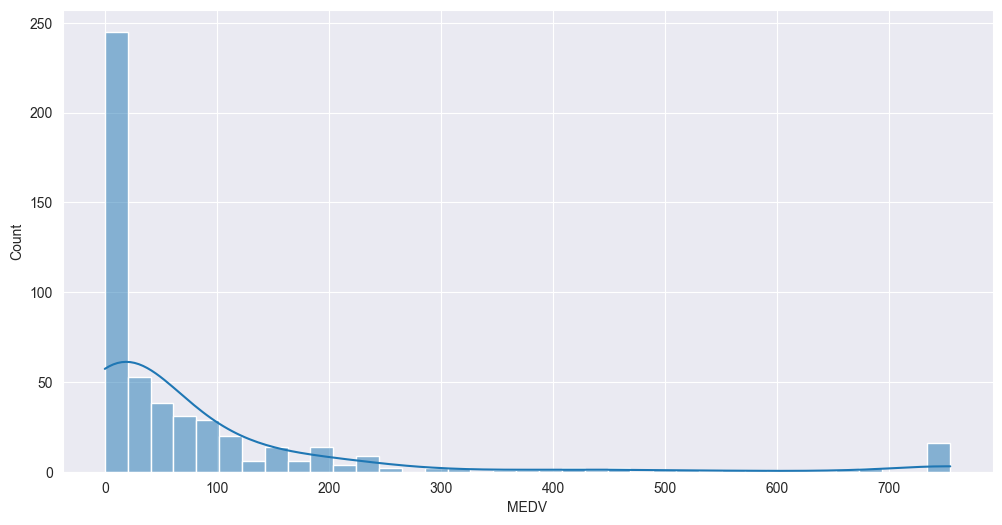

In [4]:
# let us look at the histogram for the squared errors 
plt.figure(figsize=(12,6))
sns.histplot(data=sq_error,
             kde=True)

plt.show()

The plot shows how frequent certain errors are in respect of their values.

Therefore, you will immediately notice that most errors are around zero (there is a high density around that value). Such a situation can be considered a good one,since in most cases the mean is a good approximation, but some errors are really very far from the zero and they can attain
considerable values (don't forget that the errors are squared, anyway, so the effect is emphasized).

### PseudoInverse & Other Optimization Methods 

In [10]:
# calculate the numer of observations 
observations = len(data)

# X - the feature matrix (2D array)
X = data['RM'].values.reshape((observations,1))

# y - 1D array
y = data['MEDV'].values

# add the columnof ones to X
X = np.column_stack((np.ones(observations),X))

def matrix_inverse(X,y, pseudo=False):
    if pseudo:
        return np.dot(np.linalg.pinv(np.dot(X.T,X)),np.dot(X.T,y))
    else:
        return np.dot(np.linalg.inv(np.dot(X.T, X)),np.dot(X.T,y))
    
def normal_equations(X,y):
    return np.linalg.solve(np.dot(X.T,X), np.dot(X.T,y))

In [11]:
print (matrix_inverse(X, y))
print (matrix_inverse(X, y, pseudo=True))
print (normal_equations(X, y))

[-34.67062078   9.10210898]
[-34.67062078   9.10210898]
[-34.67062078   9.10210898]


## Gradient Descent 

### 🎯 What is Gradient Descent?

Gradient Descent is an **optimization algorithm** used to **minimize a function** by iteratively moving in the direction of steepest descent, as defined by the negative of the gradient.

In simpler words:
> "It helps us find the lowest point (minimum) of a curve or surface, by repeatedly taking small steps downhill."

In machine learning, our goal is usually to **minimize the cost (error) function** — for example, in linear regression, this means finding the best values for the coefficients (weights) so that predictions are as close as possible to actual values.

---

### 🏞️ The Mountain Analogy

Imagine:
- You're blindfolded and dropped on a hilly landscape.
- Your goal is to reach the lowest valley (global minimum).
- You feel the ground and take steps downhill — little by little.
- Every time you stop, you again feel where the ground slopes down, and step that way.
- Eventually, you will reach a place where you cannot go downhill anymore.
  - If you’re lucky: ✅ It’s the global minimum.
  - If unlucky: ⚠️ It’s a local minimum (a smaller valley, but not the lowest point overall).

---

### 🧮 Why Gradient Descent is Good for Linear Regression

#### 1. **Cost Function Shape (Convex Bowl)**
- For linear regression, the cost function is convex (bowl-shaped).
- ✅ **Good news**: In convex functions, there is **only one minimum**. So no matter where you start, you will eventually reach the bottom.
- This means: **No risk of local minima**, only one global minimum!

#### 2. **Efficiency**
- Classical methods (like analytical solutions) can become computationally heavy when data is huge.
- Gradient Descent has complexity **O(n \* p)**:
  - **n** = number of observations (rows in your dataset)
  - **p** = number of features (columns in your dataset)
- This means it works well even with large datasets.

#### 3. **Iterative Process**
- Start with random coefficients (weights).
- Compute the gradient (slope of error function).
- Update the coefficients by taking a small step in the direction of the negative gradient.
- Repeat until the changes are very small (convergence).

---

### ⚙️ Formula

For linear regression, we minimize **Mean Squared Error (MSE):**

$
\text{Cost function (MSE)} = \frac{1}{n} \sum (y_i - \hat{y}_i)^2
$

Gradient Descent update rule for a weight $ w $:

$
w = w - \alpha \frac{\partial}{\partial w} J(w)
$

Where:
- $\alpha $ = learning rate (step size)
- $ \frac{\partial}{\partial w} J(w) $ = derivative of cost function w.r.t. $ w $

---

### 🚦 Risk: Local Minimum vs. Global Minimum

- ✅ **Linear models (like Linear Regression)**: Cost function is convex → Safe!
- ⚠️ **Complex models (like Neural Networks)**: Cost function is non-convex → Risk of getting stuck in local minima.

---

### 🧩 Step-by-Step: How Gradient Descent Works

1. **Initialize randomly**  
   - Start with random values for the coefficients (slopes & intercepts in linear regression).

2. **Calculate the gradient**  
   - The gradient is like a compass showing which direction is "downhill."
   - Mathematically, it’s the partial derivatives of the cost function with respect to each parameter (coefficient).

3. **Take a step (Update the parameters)**  
   - Move opposite to the gradient (since the gradient points uphill).
   - Update rule:  
     $
     \theta := \theta - \alpha \cdot \nabla J(\theta)
     $
     where:
     - $ \theta $ = parameters (weights)
     - $\alpha $= learning rate (step size)
     - $\nabla J(\theta) $= gradient of the cost function

4. **Repeat until convergence**  
   - Keep updating parameters until the change in the cost function becomes very small (meaning you’ve reached the minimum).

---

### 🧠 Important Concepts

| Term | Explanation |
|------|-------------|
| **Learning Rate ($\alpha $** | Determines the size of steps you take. Too small: slow learning. Too big: might overshoot the minimum. |
| **Epoch** | One full cycle through the entire dataset. |
| **Convergence** | When the updates become so small that further iterations don’t improve the cost function. |
| **Local Minimum** | A point where the function value is lower than its immediate surroundings, but not the global lowest point. |
| **Global Minimum** | The absolute lowest point of the function. For linear regression, it’s where we want to be! ✅ |

---

### 🔥 Why Gradient Descent is Powerful (Especially for Big Data)

- **Efficiency**: Traditional methods (like calculating the normal equation in linear regression) become computationally expensive when you have a large number of features (p) and data points (n).  
- Gradient Descent is much more scalable:  
  $
  \text{Computational Complexity: } O(n \cdot p)
  $
- This means even with millions of data points and many features, Gradient Descent is fast and effective.

---

### 🚦 Pitfalls and Precautions

- ✅ **Linear regression is safe!**  
  Linear regression has a convex cost function, so Gradient Descent will always find the global minimum.
  
- ⚠️ **Other models may have complex cost functions.**  
  In models like deep neural networks, cost functions are not convex — they can have many local minima or saddle points.

- 🧩 **Choosing the right learning rate** is crucial.  
  - Too high? Oscillations or divergence.  
  - Too low? Slow convergence.  
  - Solution: Use techniques like learning rate schedules or adaptive optimizers (e.g., Adam, RMSprop).

---

In [ ]:
X.shape, y.shape # check the shapes of the two arrays 

((506, 2), (506,))

In [29]:
import random

def random_w(p):
    # Generate a numpy array of length p with random values sampled from a normal distribution
    return np.array([np.random.normal() for j in range(p)])

def hypothesis(X, w):
    # Compute the hypothesis/prediction for given input data X and weights w
    return np.dot(X, w)

def loss(X, w, y):
    # Compute the loss/error between the predicted values and the true target values y
    return hypothesis(X, w) - y

def squared_loss(X, w, y):
    # Compute the squared loss/error between the predicted values and the true target values y
    return loss(X, w, y)**2

def gradient(X, w, y):
    # Compute gradients
    n = float(len(y))
    return np.dot(X.T, loss(X, w, y)) / n

def update(X, w, y, alpha=0.01):
    # Update weights
    return w - alpha * gradient(X, w, y)

def optimize(X, y, alpha=0.01, eta=10**-12, iterations=1000):
    # Initialize weights with random values
    w = random_w(X.shape[1]) 
    
    # List to store the path of squared loss
    path = list()
    
    # Iterate for a fixed number of iterations
    for k in range(iterations):
        # Compute the sum of squared loss (SSL) with current weights
        SSL = np.sum(squared_loss(X, w, y))
        
        # Update weights using gradient descent
        new_w = update(X, w, y, alpha=alpha)
        
        # Compute the sum of squared loss with updated weights
        new_SSL = np.sum(squared_loss(X, new_w, y))
        
        # Update weights
        w = new_w
        
        # Check if SSL improvement is within tolerance (eta) after 5 iterations
        if k >= 5 and (abs(new_SSL - SSL) <= eta):
            # If improvement is within tolerance, return current weights and path
            path.append(new_SSL)
            return w, path
        
        # Store SSL in path every 1/20th of iterations
        if k % (iterations / 20) == 0:
            path.append(new_SSL)
    
    # Return the final weights and the path of SSL
    return w, path

In [30]:
alpha = 0.048
w, path = optimize(X,y,alpha, eta = 10**-12, iterations = 25000)

print (f"These are our final coefficients: {w}")
print()
print (f"Obtained walking on this path of squared loss {path}")
len(path)

These are our final coefficients: [-34.6705854    9.10210342]

Obtained walking on this path of squared loss [np.float64(397325.24337264773), np.float64(23754.578093657023), np.float64(22461.625225814423), np.float64(22156.28280716957), np.float64(22084.173455821394), np.float64(22067.144185617366), np.float64(22063.122570691423), np.float64(22062.172830249307), np.float64(22061.94854052391), np.float64(22061.89557249318), np.float64(22061.883063617555), np.float64(22061.880109534366), np.float64(22061.879411901115), np.float64(22061.87924714877), np.float64(22061.879208241022), np.float64(22061.879199052608), np.float64(22061.879196882684), np.float64(22061.87919637023), np.float64(22061.879196249218), np.float64(22061.879196220638), np.float64(22061.879196219605)]


21

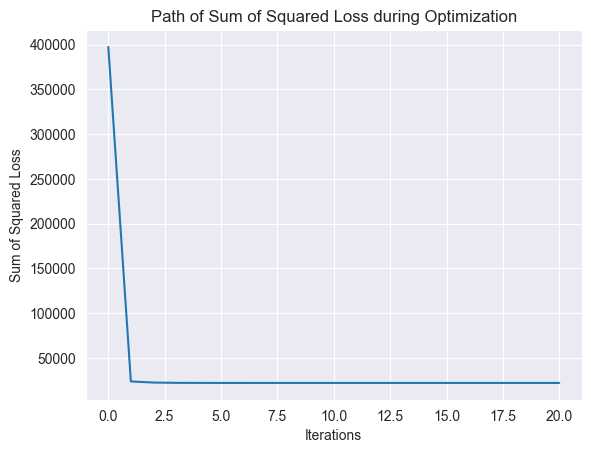

In [31]:
plt.plot(path)
plt.xlabel('Iterations')
plt.ylabel('Sum of Squared Loss')
plt.title('Path of Sum of Squared Loss during Optimization')
plt.show()

Scikit-learn linear_regression (and other linear models present in the linearmethods module) are actually powered by `gradient descent`, making
Scikitlearn our favorite choice when working in data science projects with large and big data.

# 📘 Gradient Descent for Simple Linear Regression — Math Explained

This document explains the step-by-step math behind implementing Gradient Descent for a simple linear regression model.

---

## 1. Objective

We want to find the best-fitting line:
$
y = w_0 + w_1 x
$
where:
- $ y $ is the target variable.
- $x $ is the feature.
- $ w_0 $ $ w_1 $ are weights/parameters (intercept and slope).

Our goal is to minimize the **cost function** (Mean Squared Error).

---

## 2. Cost Function (Mean Squared Error)

$
J(w) = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
$
where:
- $ n $= number of data points
- $ \hat{y}_i = w_0 + w_1 x_i $

We are trying to find $ w $ that minimizes $ J(w) $

---

## 3. Hypothesis Function

Prediction for input data $X $
$
\hat{y} = Xw
$
$X $ is the input feature matrix (including bias term), $ w $ is the weight vector.

---

## 4. Gradient of the Cost Function

To minimize the cost function, compute the partial derivatives (gradients):

$
\frac{\partial J}{\partial w_j} = - \frac{2}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i) \cdot x_{ij}
$

In vectorized form:
$
\nabla J(w) = \frac{1}{n} X^T (X^Tw - y)
$

---

## 5. Update Rule (Gradient Descent Step)

At each iteration, update the weights as follows:

$
w = w - \alpha \nabla J(w)
$

where:
- $\alpha $is the learning rate.
- $\nabla J(w) $ is the gradient.

---

## 6. Algorithm Steps

1. **Initialize** weights randomly:  
   $w = random \ values $

2. **Compute predictions**:  
   $ \hat{y} = Xw $

3. **Compute loss**:  
   $loss = \hat{y} - y $

4. **Compute gradient**:  
   $ gradient = \frac{1}{n} X^T loss $

5. **Update weights**:  
   $ w = w - \alpha \times gradient $

6. **Repeat** until convergence (loss stops changing or reaches max iterations).

---

## 7. Convergence

The algorithm stops when:
- The change in cost function is less than a small threshold $ \eta $, **or**
- Maximum iterations are reached.

---

## 8. Notes

- **Learning rate $ \alpha $**: Too high → overshooting, too low → slow convergence.
- **Convexity**: Linear regression has a convex cost function, so gradient descent will converge to the global minimum.

---

## Visual Intuition

Imagine you are blindfolded in a bowl-shaped valley (cost function).  
By feeling the slope of the ground under your feet (gradient), you step downhill at every iteration, until you reach the lowest point (minimum cost).

---

### ✅ Summary

- Cost Function: $ J(w) = \frac{1}{n} \sum (y - \hat{y})^2 $
- Gradient: $ \nabla J(w) = \frac{1}{n} X^T (Xw - y) $
- Update Rule: $ w = w - \alpha \nabla J(w) $

---


## Simple Linear Regression using Scikit-learn

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [33]:
# first let us use the df dataset
df

,RM,MEDV
0,6.575,24.0
1,6.421,21.6
2,7.185,34.7
3,6.998,33.4
4,7.147,36.2
...,...,...
501,6.593,22.4
502,6.120,20.6
503,6.976,23.9
504,6.794,22.0


In [34]:
# let us now separate out the independent and the dependent variables 
X = df['RM'] # independent 
y = df['MEDV'] # dependent 

In [35]:
# note the shape 
X.shape, y.shape

((506,), (506,))

**NOTE**
- Always, while doing modelling with scikit-learn, it is a better choice to convert X to a matrix or a 2D array, if it's not!

Here the shape of X tells us that X is a 1D array. Hence, we should convert it to a 2D array.

In [36]:
# convert X to a 2D array
X = np.reshape(X, shape=(len(df),1))
X.shape

(506, 1)

In [37]:
# let us now do the train test split 
X_train, X_test, y_train, y_test  = train_test_split(X,y,
                                                     test_size=0.2,
                                                     random_state=2)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((404, 1), (102, 1), (404,), (102,))

### 🎯 **Why Standardization Is Helpful (Especially for Linear Regression and Distance-Based Methods)**

---

## 🧠 Imagine This First:
You're running a linear regression to predict **house prices** based on two features:
- 🏠 `Area (sq ft)` → ranges from **500 to 5000**
- 🚪 `Number of rooms` → ranges from **1 to 10**

Now, tell me: **Which variable do you think will dominate the learning algorithm?**

**Answer:** `Area`, because its values are much larger in magnitude!

Even if `Number of rooms` is very important, it will get **dwarfed** numerically. That’s where **standardization** comes in.

---

## ✅ What is Standardization?

Standardization rescales features to have:

- **Mean = 0**
- **Standard deviation = 1**

Using the formula:  
$
X_{\text{scaled}} = \frac{X - \text{mean}(X)}{\text{std}(X)}
$

This puts *all features on the same scale*.

---

## 📌 Why It's Crucial in Linear Regression

Linear regression tries to find the best-fit line by minimizing a cost function (like MSE) using gradient descent or matrix inversion. The optimization involves **weights** and **distances**, and here's why standardization matters:

### 1. 🧮 **Better Optimization (Gradient Descent)**
- If one feature has a much larger scale, its gradient will be much steeper.
- The model will **update the weight** of that feature more aggressively.
- Result: **unstable convergence** and biased learning.
- Standardization makes optimization **smooth and stable**.

---

### 2. ⚖️ **Fair Weight Interpretation**
- Without standardization, coefficients reflect scale differences.
- After standardization, the coefficients show **true feature importance**, since they all start from the same scale.

---

### 3. 📉 **Numerical Stability**
- Some optimization methods (like normal equations) involve matrix inversions.
- Very large or very small feature values → ill-conditioned matrices.
- This causes numerical issues or huge errors.
- Standardization **reduces** the chance of this.

---

## 🧮 Why It's Important in Distance-Based Algorithms

In methods like:
- **KNN (K-Nearest Neighbors)**
- **K-Means Clustering**
- **SVM (with RBF Kernel)**
- **PCA**

Distance or similarity is calculated using formulas like:
$
\text{distance} = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \ldots}
$

If features are not standardized:
- Features with **larger ranges** will dominate distance.
- You'll get **misleading clusters** or **nearest neighbors**.

---

## 💡 Real-World Analogy

Imagine trying to find out who’s taller between two people:
- One person’s height is in **centimeters**
- The other’s is in **kilometers**

Clearly, without converting units (scaling), you’re going to get a wildly inaccurate answer. Standardization is just that—putting everyone in **comparable units**.

---

## 🧪 Summary

| Why Standardization?         | Benefit                                      |
|-----------------------------|-----------------------------------------------|
| Different feature scales     | Ensures fair weight learning                 |
| Gradient-based methods       | Smooth, stable convergence                   |
| Matrix operations            | Better numerical stability                   |
| Distance-based algorithms    | Prevents misleading similarity calculations  |
---

In [38]:
# Standardization
std = StandardScaler()

# fit and transform X_train and use the fitted model to transform X_test
X_train = std.fit_transform(X_train)
X_test = std.transform(X_test)

In [39]:
# see the stats
print(f'The fitted mean : {std.mean_}')
print(f'The fitted standard deviation : {std.scale_}')

The fitted mean : [6.28537624]
The fitted standard deviation : [0.70095816]


In [40]:
# let us check what is the mean and std of X_train now - the mean should be 0 and std be 1 
mean = round(np.mean(X_train, axis=0)[0],2)
stdev = np.std(X_train, axis=0)[0]
mean, stdev

(np.float64(0.0), np.float64(1.0))

Thus, clearly, X_train is now standardized!

In [41]:
# Linear Regression 
reg = LinearRegression(fit_intercept=True)

# fit the regression model 
fitted_reg = reg.fit(X=X_train, y=y_train)
fitted_reg

LinearRegression()

In [42]:
# let us see the coeffecients of the model
print(f'The intercept of the model is : {fitted_reg.intercept_}')
print(f'The betas of the model are : {fitted_reg.coef_}')

The intercept of the model is : 22.441336633663354
The betas of the model are : [6.13292429]


In [43]:
# let us now predict 
y_pred = fitted_reg.predict(X_test)

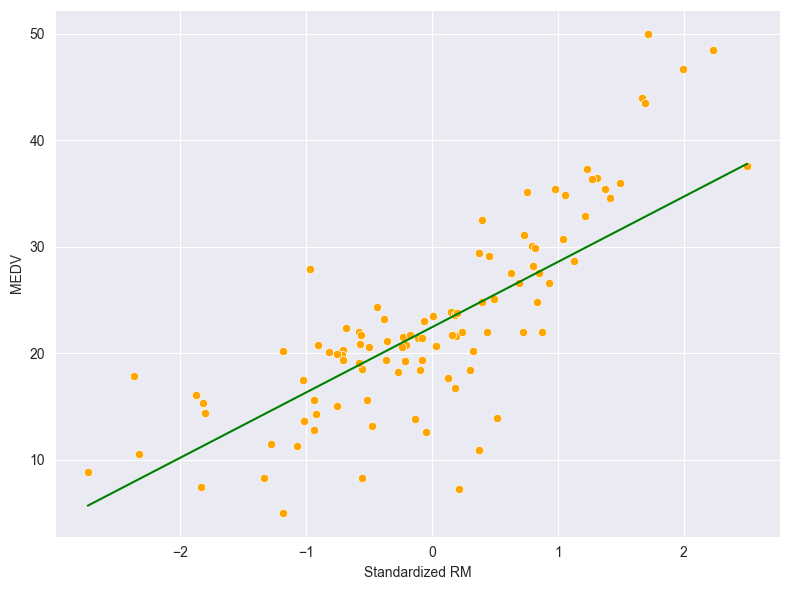

In [44]:

plt.figure(figsize=(8,6))
sns.scatterplot(x=np.reshape(X_test, shape=(len(X_test),)),
                y=y_test, 
                color='orange')

sns.lineplot(x= np.reshape(X_test, shape=(len(X_test),)),
             y=y_pred,
             color='green')

plt.xlabel('Standardized RM')
plt.tight_layout()
plt.show()

In [45]:
# let us now calculate the r squared 
from sklearn.metrics import r2_score

r = r2_score(y_true=y_test,
         y_pred=y_pred)

print(f'The model can explain {r*100:.2f}% of the variance of the target variable.')

The model can explain 63.35% of the variance of the target variable.


- The **MSE** tells you **how far off your predictions are, on average, from the actual values.**

- It’s the objective function that most linear regression models try to minimize during training.

- A **lower MSE** means your line is fitting the data well.

- A **higher MSE** indicates the model isn't capturing the relationship well.

In [46]:
from sklearn.metrics import root_mean_squared_error

root_mean_squared_error(y_true=y_test,
                        y_pred=y_pred)

5.536929907868704

The units of MSE are the square of your target variable’s unit. If you want error in the same unit as your target, we use RMSE

<Axes: ylabel='MEDV'>

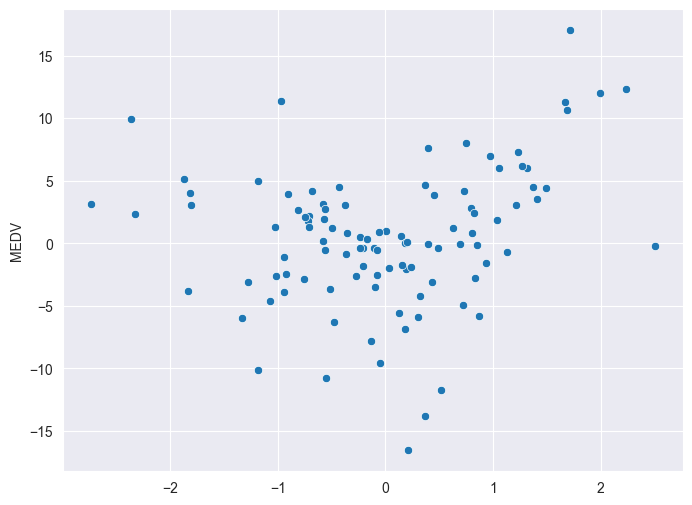

In [47]:
# let us now plot the residuals and see if they are random
residuals = y_test - y_pred

plt.figure(figsize=(8,6))
sns.scatterplot(x=np.reshape(X_test, shape=(len(X_test),)),
                y=residuals
                )

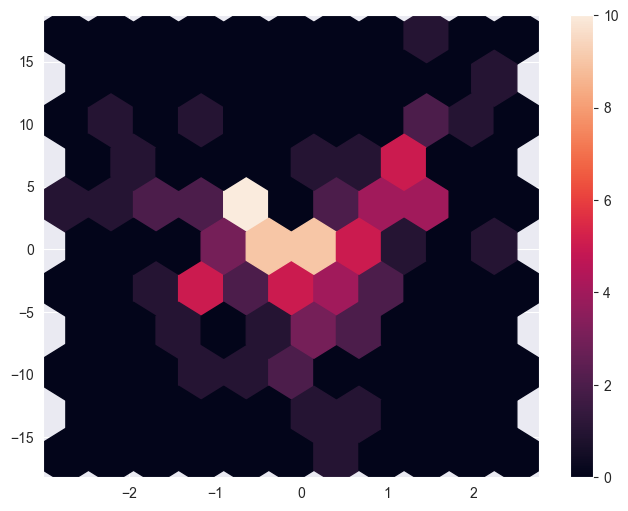

In [48]:
# let us do a hexbin plot 
plt.figure(figsize=(8,6))
plt.hexbin(x=np.reshape(X_test, shape=(len(X_test),)),
           y=residuals,
           gridsize=10)
plt.colorbar()

Text(0.5, 0, 'Residuals Distribution')

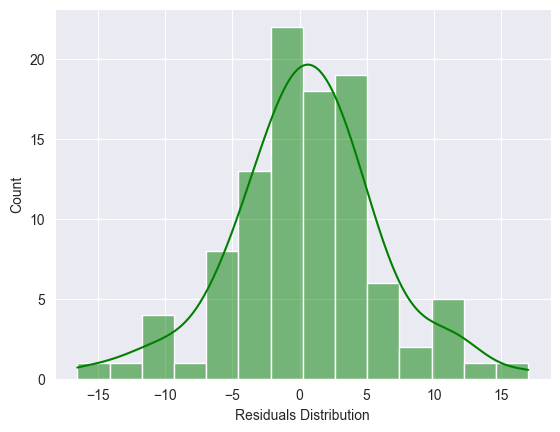

In [52]:
# let us check the distribution too! 
sns.histplot(x=residuals,
             kde=True,
             color='green')

plt.xlabel('Residuals Distribution')

We now have **two complementary views of your residuals**:

1. ✅ **Histogram with KDE (distribution of residuals)**
2. ✅ **Hexbin plot (residuals vs. `x_test`)**

Let’s combine both to understand the residuals **more holistically**.

---

### 📊 Histogram + KDE Insights

This histogram shows:
- A **bell-shaped**, roughly **symmetric** curve.
- That suggests **residuals are approximately normally distributed**.
- Normality of residuals is a **good sign** — it supports the assumption that the model errors are random.

BUT...

---

### 🔍 Combined Insights with Hexbin Plot

| Observation from Hexbin       | Observation from Histogram | Combined Interpretation                                          |
|-------------------------------|-----------------------------|------------------------------------------------------------------|
| U-shaped residual pattern     | Normal distribution         | Even though residuals are centered, they vary systematically with `x_test`. Indicates **non-linearity**. |
| Higher residuals on extremes  | Fewer extreme values        | Model errors increase on edge `x_test` values, but it doesn’t happen frequently. Possibly okay unless you're interested in those ranges. |
| Residuals cluster near zero   | Peak near 0 in histogram    | Most predictions are close to actual — good overall accuracy near mean of `x_test`. |

---

### ⚠️ What This Tells You

- ✅ Your model is **well-centered** (errors are balanced).
- ❌ Your model **fails to fully capture** the relationship between features and target, likely due to **missing non-linear terms**.
- ✅ Residuals **do not have extreme skew** — that's good.

---

### 🧠 Next Steps

To fix the issues highlighted by the **hexbin**, while keeping the benefits seen in the **histogram**:

1. **Try Polynomial Regression**  
   Add non-linear terms to the model to account for curvature in residuals.
   ```python
   from sklearn.preprocessing import PolynomialFeatures
   poly = PolynomialFeatures(degree=2)
   X_poly = poly.fit_transform(X)
   ```
2. **Try Tree-based Models** (no need to manually specify non-linearity)
   ```python
   from sklearn.ensemble import RandomForestRegressor
   ```
3. **Add interaction or derived features** — maybe your features interact in a way your linear model isn't capturing.

---